In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   |Tree status in year 1 post-fire. (0=alive, 1=dead). Counted in growing seasons − if fire occurred in spring prior to bud break, 1 year post-fire is that same year as fire. If fire occurred during growing season or fall, 1 year post-fire is the next calendar year after fire.
| YrFireName                  |A unique identifier for each fire event that includes the year of the fire and the fire name; YEAR - Fire                                     
| Times_burned                |The number of times this tree was burned.                                             
| Species                     |                                                     
| Genus_species               |Genus and species of tree.                                       
| DBH_cm                      |Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number. Symbols follow those in the PLANTS National Database (http://plants.usda.gov). 2TREE = unknown tree species. 
| HT_m                        |Pre-fire tree height rounded to nearest 0.01 m (m=meters). NA = not assessed.
| CR_pre                      |Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed. 
| CR_post                     |Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

/tmp/ipykernel_1394479/1765753220.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


In [3]:
#Filter for columns of interest
trees_dat = trees_dat[['YrFireName', 'Times_burned', 'Species', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post', 'yr1status']]

# Check for incomplete observations
na_counts = trees_dat.isna().sum().sum()

# Remove any rows containing NAs
trees_dat = trees_dat.dropna()

# How many observations does that leave us with?
no_nas = trees_dat.shape[0]

print(f"There were {na_counts} NAs in the dataframe. After removing NAs, we are left with {no_nas} observations, or rows.")

There were 348833 NAs in the dataframe. After removing NAs, we are left with 36509 observations, or rows.


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [4]:
# Check data types
trees_dat.dtypes

YrFireName        object
Times_burned       int64
Species           object
Genus_species     object
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
yr1status        float64
dtype: object

In [5]:
# Change rows to df moking our categorial data numeric
for col in ['YrFireName', 'Species', 'Genus_species']:
    trees_dat[f"{col}_cat"] = trees_dat[col].astype('category').cat.codes
    
# Check df
trees_dat.head(3)

,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post,yr1status,YrFireName_cat,Species_cat,Genus_species_cat
500,2003 - Griff,1,ABAM,Abies_amabilis,71.374,41.76,0.84,0.74,0.0,37,0,0
501,2003 - Griff,1,ABAM,Abies_amabilis,23.622,12.80,0.60,0.57,0.0,37,0,0
502,2003 - Griff,1,ABAM,Abies_amabilis,46.228,34.75,0.75,0.59,0.0,37,0,0


In [6]:
# Check dtypes
trees_dat.dtypes

YrFireName            object
Times_burned           int64
Species               object
Genus_species         object
DBH_cm               float64
HT_m                 float64
CR_pre               float64
CR_post              float64
yr1status            float64
YrFireName_cat          int8
Species_cat             int8
Genus_species_cat       int8
dtype: object

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [7]:
# Assign predictor and outcome variables. Y is the target variable or outcome
X = trees_dat.drop(['yr1status', 'YrFireName', 'Species', 'Genus_species'], axis = 1)
y = trees_dat['yr1status']

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Standardize or scale predictor variables, essentially scaling until their means and standard deviations match
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [8]:
# Verify the training and testing set size
print("Training set observations:", X_train_scaled.shape[0])
print("Testing set observations:", X_test_scaled.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [9]:
# Fit Logistic Regression...is a classifier
log_model = LogisticRegression().fit(X_train_scaled, y_train)

# Make that prediction!
y_train_pred = log_model.predict(X_train_scaled)

# Assess accuracy and write it as a percentage 
score = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {score * 100:.2f}%")

Training Accuracy: 94.51%


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 94.02%


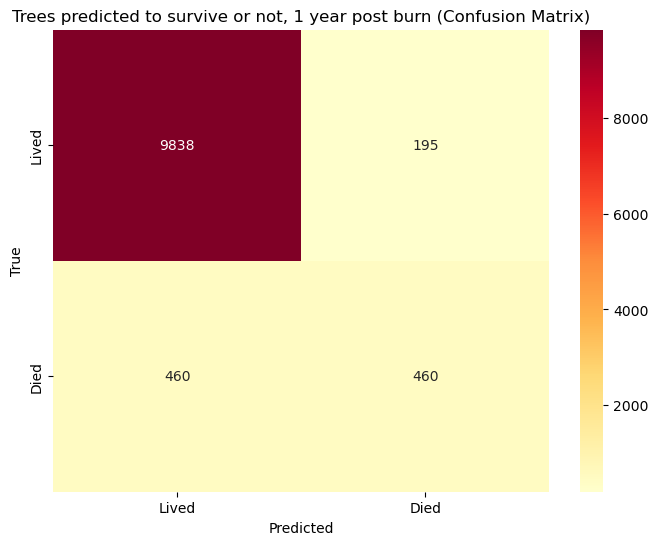

In [16]:
# Make those test predictions!
y_test_pred = log_model.predict(X_test_scaled)

# How accurate was the prediction?
score2 = accuracy_score(y_test, y_test_pred)

# Print the calculated accuracy as a percentage
print(f"Accuracy: {score2 * 100:.2f}%")

# Create confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix 
plt.figure(figsize = (8,6))
sns.heatmap(confusion, fmt = 'd', cmap = 'YlOrRd', xticklabels = ['Lived', 'Died'],
               yticklabels = ['Lived', 'Died'], annot = True)
plt.title('Trees predicted to survive or not, 1 year post burn (Confusion Matrix)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

*To answer the question of how the model performed, I need to calculate the sensitivity and specificity of the model. This will also help me determine if there is a class imbalance....BAILEY WORK ON THIS MORE*

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

*If there is a class imbalance, even if we have a model that always predicts the majority class, we would still have high accuracy. Compared to the logistic regression, the accuracy might be a little lower, but probably not as low as I might suspect.*

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy:  91.72%

Dummy Confusion Matrix:


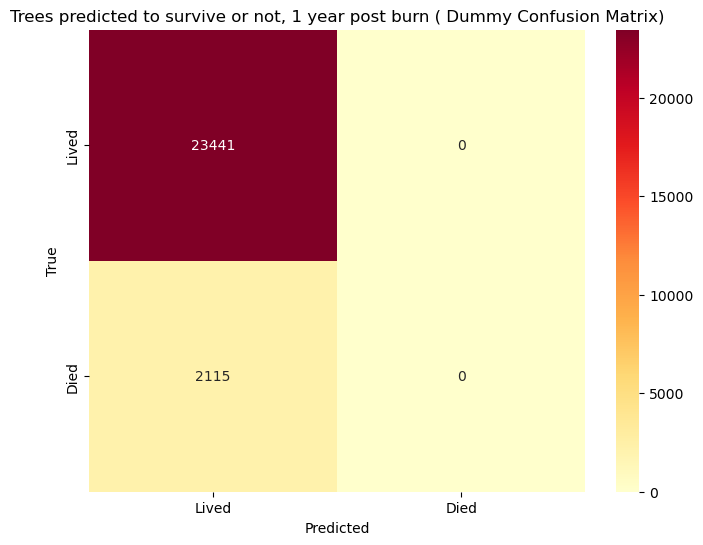

In [18]:
# Create and fit a dummy majority classifier
dummy = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train)

# Make predictions on training data
y_train_pred_dummy = dummy.predict(X_train_scaled)

# Calculate accuracy
dummy_accuracy = accuracy_score(y_train, y_train_pred_dummy)

# Create confusion matrix
confusion2 = confusion_matrix(y_train, y_train_pred_dummy)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {dummy_accuracy * 100: .2f}%")
print("\nDummy Confusion Matrix:")

# Plot the confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(confusion2, fmt = 'd', cmap = 'YlOrRd', xticklabels = ['Lived', 'Died'],
               yticklabels = ['Lived', 'Died'], annot = True)
plt.title('Trees predicted to survive or not, 1 year post burn ( Dummy Confusion Matrix)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [ ]:
# Logistic classifier AUC
...
print(f"Logistic AUC: ")

In [ ]:
# Dummy classifier AUC
...
print(f"Dummy AUC: ")

# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

*Your answer here*

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [ ]:
...

# Print the sorted feature importance
print(importance_df)

Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

*Your answer here*